# Feature selection

In this section, our objective is to determine the optimal number of features and extract a list of those features for training our machine learning model. This process, known as feature selection, is essential for enhancing model performance, reducing complexity, and improving interpretability. By identifying and selecting the most relevant features, we aim to improve the efficiency of our models while ensuring they maintain high predictive accuracy.

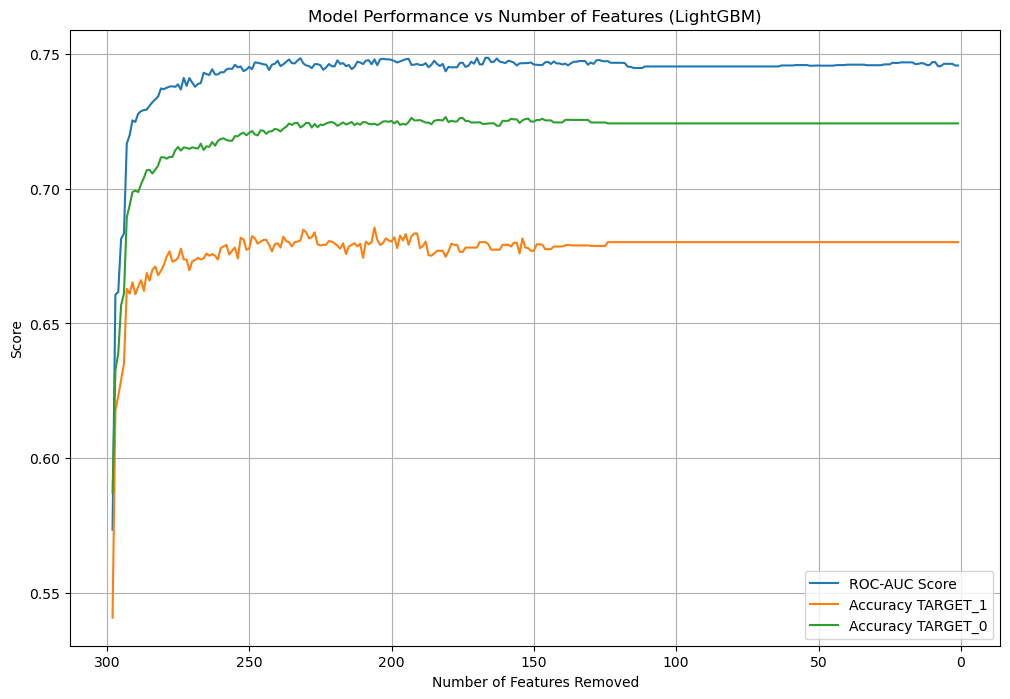

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt

df = pd.read_csv('../data/app_train_extended.csv')
y = df['TARGET']
X = df.drop('TARGET', axis=1).replace([np.inf, -np.inf], np.nan)

for col in X.select_dtypes(include=['object']).columns:
    X[col] = X[col].astype('category')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
scale_pos_weight = (y == 0).sum() / (y == 1).sum()

remaining_features = list(X_train.columns)
feature_importance_ranking = []
scores = []
accuracy_target_1 = []
accuracy_target_0 = []

params = {
    'max_depth': 6,
    'min_data_in_leaf': 20,
    'min_gain_to_split': 0.01,
    'scale_pos_weight': scale_pos_weight,
    'verbose': -1
}

while remaining_features:
    model = LGBMClassifier(**params)
    model.fit(X_train[remaining_features], y_train)

    roc_auc_score = cross_val_score(model, X_test[remaining_features], y_test, cv=StratifiedKFold(3), scoring='roc_auc').mean()
    scores.append(roc_auc_score)
    
    y_pred = model.predict(X_test[remaining_features])
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    accuracy_target_1.append(tp / (tp + fn))
    accuracy_target_0.append(tn / (tn + fp))

    feature_importances = model.feature_importances_
    feature_importance_dict = {feature: importance for feature, importance in zip(remaining_features, feature_importances)}
    least_important_feature = min(feature_importance_dict, key=feature_importance_dict.get)
    
    feature_importance_ranking.append((least_important_feature, feature_importance_dict[least_important_feature]))
    remaining_features.remove(least_important_feature)

feature_importance_ranking.reverse()

plt.figure(figsize=(12, 8))
plt.plot(list(range(1, len(scores)+1)), scores, label='ROC-AUC Score', marker='none')
plt.plot(list(range(1, len(scores)+1)), accuracy_target_1, label='Accuracy TARGET_1', marker='none')
plt.plot(list(range(1, len(scores)+1)), accuracy_target_0, label='Accuracy TARGET_0', marker='none')
plt.title('Model Performance vs Number of Features (LightGBM)')
plt.xlabel('Number of Features Removed')
plt.ylabel('Score')
plt.legend()
plt.gca().invert_xaxis()
plt.grid(True)
plt.show()


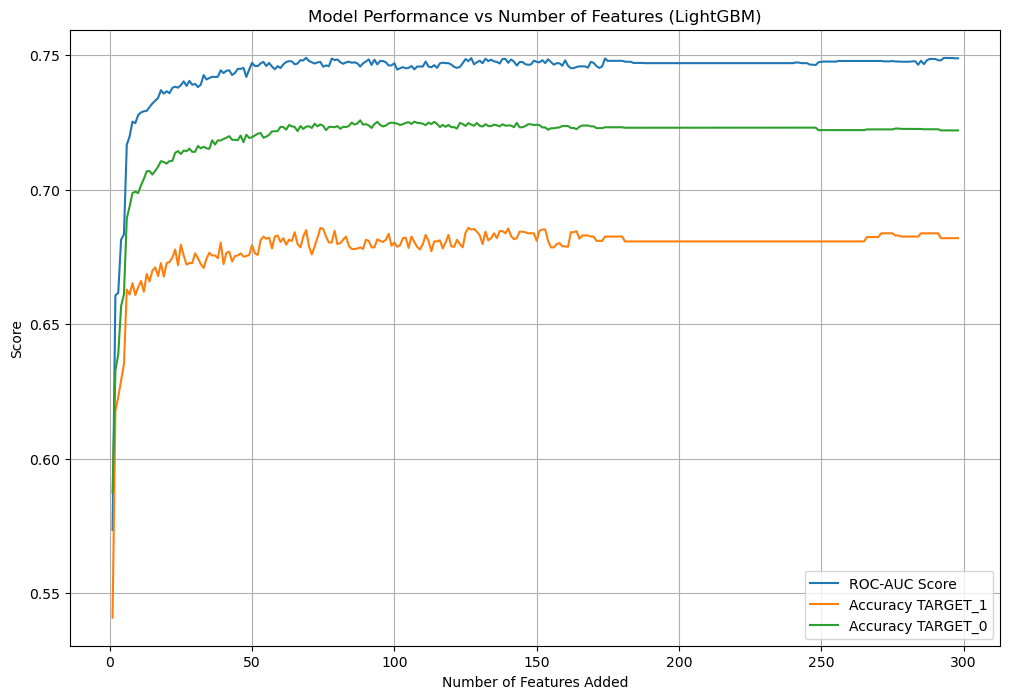

In [2]:
ranked_features = [feature for feature, _ in feature_importance_ranking]

X = df[ranked_features].copy()
for col in X.select_dtypes(include=['object', 'category']).columns:
    X[col] = X[col].astype('category')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
scale_pos_weight = (y == 0).sum() / (y == 1).sum()
scores = []
accuracy_target_1 = []
accuracy_target_0 = []
feature_counts = []

params = {
    'max_depth': 6,
    'min_data_in_leaf': 20,
    'min_gain_to_split': 0.01,
    'scale_pos_weight': scale_pos_weight,
    'verbose': -1
}

for i in range(1, len(ranked_features) + 1):
    current_features = ranked_features[:i]
    
    X_train_subset = X_train[current_features].copy()
    X_test_subset = X_test[current_features].copy()
    
    model = model = LGBMClassifier(**params)
    model.fit(X_train_subset, y_train)
    
    y_pred = model.predict(X_test_subset)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    accuracy_target_1.append(tp / (tp + fn))
    accuracy_target_0.append(tn / (tn + fp))
    
    score = cross_val_score(model, X_test_subset, y_test, cv=StratifiedKFold(3), scoring='roc_auc').mean()
    scores.append(score)
    feature_counts.append(i)

plt.figure(figsize=(12, 8))
plt.plot(feature_counts, scores, label='ROC-AUC Score', marker='none')
plt.plot(feature_counts, accuracy_target_1, label='Accuracy TARGET_1', marker='none')
plt.plot(feature_counts, accuracy_target_0, label='Accuracy TARGET_0', marker='none')
plt.title('Model Performance vs Number of Features (LightGBM)')
plt.xlabel('Number of Features Added')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
selected_features = ranked_features[:125]
selected_features_df = pd.DataFrame({'Selected_Features': selected_features})
selected_features_df.to_csv('../data/selected_features.csv', index=False)

## Conclusions

In conclusion, our analysis reveals that utilizing a feature set comprising 125 features is optimal for training our machine learning model, balancing both training time and predictive accuracy. The ROC-AUC score chart, along with the accuracy metrics for the true target categories, suggests that this feature selection strategy strikes a balance between model complexity and performance.

The ROC-AUC score, a measure of the model's ability to distinguish between positive and negative classes, demonstrates a steady performance trend as the number of features increases. Additionally, the accuracy metrics for both target categories indicate that the model achieves satisfactory performance across different feature subsets.